### Problem Statement
For any video YouTube provides some data metrices such as Views, Likes, Comments, Shares, etc available publically.
Based on these data metrices one has to predict the ad views i.e. views earned through advertizements. External library 
or any dataset can be used for the prediction.

#### [Data Set](https://github.com/vidoolytech/hiringtask/tree/master/machine_learning/ad_org)

In [1]:
#Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
from scipy.stats import norm, skew

%matplotlib inline

#Checking data files
print(os.listdir('data/mn'))

C:\Users\parve\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


['ad_org_test.csv', 'ad_org_train.csv', 'output.csv']


In [2]:
df_train = pd.read_csv('data/mn/ad_org_train.csv',)
df_test = pd.read_csv('data/mn/ad_org_test.csv')

#shape of Data provided
print('Size of train & Test is :--> ',df_train.shape, df_test.shape)

Size of train & Test is :-->  (14999, 9) (8764, 8)


In [3]:
df_train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [4]:
df_test.head()

,vidid,views,likes,dislikes,comment,published,duration,category
0,VID_1054,440238,6153,218,1377,2017-02-18,PT7M29S,B
1,VID_18629,1040132,8171,340,1047,2016-06-28,PT6M29S,F
2,VID_13967,28534,31,11,1,2014-03-10,PT37M54S,D
3,VID_19442,1316715,2284,250,274,2010-06-05,PT9M55S,G
4,VID_770,1893173,2519,225,116,2016-09-03,PT3M8S,B


### Uniqueness in Data

In [5]:
for i in df_train.columns:
    print(i,len(df_train[i].value_counts()))

vidid 14999
adview 999
views 14588
likes 4789
dislikes 1546
comment 2007
published 2386
duration 3146
category 8


In [6]:
# Data Leakage check 
lek = pd.concat([df_train.vidid,df_test.vidid])

if lek.shape[0] == len(lek.value_counts()):
    print('No Leaking')
else:
    print('data leaking')

No Leaking


In [7]:
# Checking Missing Values in Data
print(df_train.isnull().sum())

# # Test
#print(df_test.isnull().sum())

vidid        0
adview       0
views        0
likes        0
dislikes     0
comment      0
published    0
duration     0
category     0
dtype: int64


No mising values found

### Data Exploration and Data Preprocessing

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
vidid        14999 non-null object
adview       14999 non-null int64
views        14999 non-null object
likes        14999 non-null object
dislikes     14999 non-null object
comment      14999 non-null object
published    14999 non-null object
duration     14999 non-null object
category     14999 non-null object
dtypes: int64(1), object(8)
memory usage: 1.0+ MB


In [9]:
#Merging Data Frame Test & Train
df = pd.concat([df_train,df_test])

In [10]:
# # Finding all 'F' values converting them as nan and Also changing the data type to numeric
def f_to_nan(col,df):
    print("{} has a value 'F' =>  {}".format(col,len(df[df[col] == 'F'])))
    df.loc[df[col] == 'F',col] = np.nan  #  # changing 'F' value to NaN
    df[col] = df[col].astype(np.number) #  # converting to float
    df[col] = df[col]
    return df

for i in ['views','dislikes','likes','comment']:
    df = f_to_nan(i,df)

views has a value 'F' =>  3
dislikes has a value 'F' =>  243
likes has a value 'F' =>  243
comment has a value 'F' =>  384


In [11]:
#Handling duration variable
hr,minut,sec,totalsec = [],[],[],[]

for i in df.duration:
    i = i.replace('PT','')
    i = pd.to_timedelta(i)
    hr.append(i.seconds // 3600)
    minut.append((i.seconds // 60) % 60)
    sec.append(i.seconds % 60)
    totalsec.append(i.seconds) 

In [12]:
#Handling published variable
day,mnth,yr = [],[],[]

for i in df.published:
    i = pd.to_datetime(i)
    day.append(i.day)
    mnth.append(i.month)
    yr.append(i.year)

In [13]:
df['hr'] = hr
df['minut'] = minut
df['sec'] = sec
df['totalsec'] = totalsec

df['day'] = day
df['mnth'] = mnth
df['yr'] = yr
df = df.drop(['duration','published'],axis = 1)

In [14]:
#sns.pairplot(df)
#plt.show()

#### [ 'Views' ]  'F' value imputation via mean

In [15]:
# # Filling Views with Mean
print('NaN => ',df.views.isnull().sum())
print("Min = {}\t Max =\t{}\t Mean =\t{}\t Median = {}".format\
      (min(df.views),max(df.views),round(df.views.mean()),df.views.median()))

#imputing
df.views = df.views.fillna(round(df.views.mean()))

NaN =>  3
Min = 27.0	 Max =	225147758.0	 Mean =	729482	 Median = 157522.5


#### [ 'Likes' ]  'F' value imputation via random forest

In [16]:
## likes // 
print('NaN => ',df.likes.isnull().sum())
print("Min = {}\t Max =\t{}\t Mean =\t{}\t Median = {}".format\
      (min(df.likes),max(df.likes),round(df.likes.mean()),df.likes.median()))

#here via Randomforest prediction fits best than normal mean or nearest neighbour value or LR with likes and views
#as likes can't be more than views 

NaN =>  243
Min = 0.0	 Max =	320072.0	 Mean =	2815	 Median = 445.0


In [17]:
#from sklearn.preprocessing import LabelEncoder
df['category'] = LabelEncoder().fit_transform(df.category)
df['category'] = df.category.astype('object')

like_train = df[['category','views','hr', 'minut', 'sec','day', 'mnth', 'yr','likes']].dropna()
like_test = df.loc[df.likes.isnull(),['category','views','hr', 'minut', 'sec','day', 'mnth', 'yr','likes','vidid']]

#Data 
X_train_like, y_train_like = like_train.iloc[:,:-1].values, like_train.iloc[:,-1].values
X_test_like = like_test.iloc[:,:-2].values


#from sklearn.ensemble import RandomForestRegressor
def fillna_rf(X_train, y_train,X_test):
    rf = RandomForestRegressor(random_state=101,n_jobs=-1).fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    return y_pred

like_test['likes'] = fillna_rf(X_train_like, y_train_like,X_test_like)
# # like_test[like_test.views < like_test.likes]  # 0 values

#imputing_values
lik_vid = like_test.vidid.tolist()
for i in lik_vid:
    df.loc[df.vidid == i, 'likes'] = like_test.loc[like_test.vidid == i, 'likes']

#### [ 'dislikes' ]  ' F ' value imputation via random forest

In [18]:
## dislikes // views
print('NaN => ',df.dislikes.isnull().sum())
print("Min = {}\t Max =\t{}\t Mean =\t{}\t Median = {}".format\
      (min(df.dislikes),max(df.dislikes),round(df.dislikes.mean()),df.dislikes.median()))

NaN =>  243
Min = 0.0	 Max =	49449.0	 Mean =	259	 Median = 38.0


In [19]:
# #Imputation
dislike_train = df[['category','views','hr', 'minut', 'sec','day', 'mnth', 'yr','likes','dislikes']].dropna()
dislike_test = df.loc[df.dislikes.isnull(),\
                                  ['category','views','hr', 'minut', 'sec','day', 'mnth', 'yr','likes','dislikes','vidid']]

#Data 
X_train_dislike, y_train_dislike = dislike_train.iloc[:,:-1].values, dislike_train.iloc[:,-1].values
X_test_dislike = dislike_test.iloc[:,:-2].values

dislike_test['dislikes'] = fillna_rf(X_train_dislike, y_train_dislike,X_test_dislike)
# # dislike_test[dislike_test.views < dislike_test.likes]  # 0 values

#imputing_values
dislik_vid = dislike_test.vidid.tolist()
for i in dislik_vid:
    df.loc[df.vidid == i, 'dislikes'] = dislike_test.loc[dislike_test.vidid == i, 'dislikes']

#### [ 'comment' ]  ' F ' value imputation via random forest

In [20]:
## Comment // likes 
print('NaN => ',df.comment.isnull().sum())
print("Min = {}\t Max =\t{}\t Mean =\t{}\t Median = {}".format\
      (min(df.comment),max(df.comment),round(df.comment.mean()),df.comment.median()))

#min -- view = 27 -- comment == 0  --- likes = 0 --- dislikes = 0 
#max -- view = 225147758 -- comment == 85250  --- likes = 320072 --- dislikes = 49449 

NaN =>  384
Min = 0.0	 Max =	85250.0	 Mean =	430	 Median = 46.0


In [21]:
com_train = df[['category','views','hr', 'minut', 'sec','day', 'mnth', 'yr','likes','dislikes','comment']].dropna()
com_test = df.loc[df.comment.isnull(),\
                  ['category','views','hr', 'minut', 'sec','day', 'mnth', 'yr','likes','dislikes','comment','vidid']]

#Data 
X_train_com, y_train_com = com_train.iloc[:,:-1].values, com_train.iloc[:,-1].values
X_test_com = com_test.iloc[:,:-2].values

com_test['comment'] = fillna_rf(X_train_com, y_train_com,X_test_com)
# # com_test[com_test.views < com_test.likes]  # 0 values

#imputing_values
com_vid = com_test.vidid.tolist()
for i in com_vid:
    df.loc[df.vidid == i, 'comment'] = com_test.loc[com_test.vidid == i, 'comment']

In [22]:
df['watch'] = df.views - (df.comment + df.likes + df.dislikes)
df.head()

,adview,category,comment,dislikes,likes,vidid,views,hr,minut,sec,totalsec,day,mnth,yr,watch
0,40.0,5,1095.0,363.0,8523.0,VID_18655,1031602.0,0,7,37,457,14,9,2016,1021621.0
1,2.0,3,6.0,2.0,56.0,VID_14135,1707.0,0,9,30,570,1,10,2016,1643.0
2,1.0,2,2.0,0.0,25.0,VID_2187,2023.0,0,2,16,136,2,7,2016,1996.0
3,6.0,7,153.0,161.0,777.0,VID_23096,620860.0,0,4,22,262,27,7,2016,619769.0
4,1.0,3,0.0,0.0,1.0,VID_10175,666.0,0,0,31,31,29,6,2016,665.0


In [23]:
#Changing Float data types to int
for i in ['comment','dislikes','likes','views','watch']:
    df[i] = df[i].astype(np.int64)
    
for i in ['hr','mnth','yr','category']:
    df[i] = df[i].astype(str)

-------------
-------------------

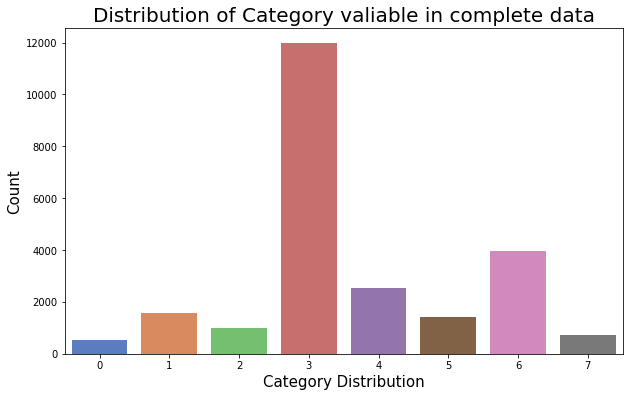

In [24]:
#Categorical Variable data distribution
plt.figure(figsize=(10,6))
sns.countplot(x = df.category,palette='muted')
plt.xlabel('Category Distribution', fontsize= 15)
plt.ylabel('Count', fontsize= 15)
plt.title("Distribution of Category valiable in complete data",fontsize= 20)
plt.show()

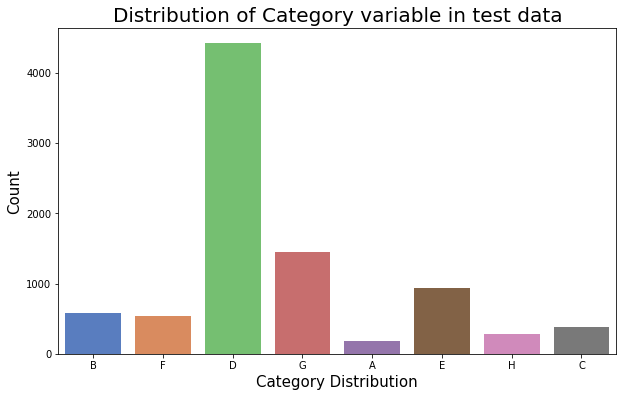

In [25]:
#Categorical Variable data distribution
plt.figure(figsize=(10,6))
sns.countplot(x = df_test.category,palette='muted')
plt.xlabel('Category Distribution', fontsize= 15)
plt.ylabel('Count', fontsize= 15)
plt.title("Distribution of Category variable in test data",fontsize= 20)
plt.show()

In [26]:
#Relationational bar graph for checking data distribution
def diff_bar(x,y):
    df.groupby([x,y]).size().unstack(level=-1).plot(kind='bar', figsize=(30,10))
    plt.xlabel(x,fontsize= 25)
    plt.ylabel('count',fontsize= 25)
    plt.legend(loc=0,fontsize= 25)
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    plt.title("{X} Vs {Y}".format(X=x,Y=y),fontsize = 40)
    #plt.savefig("{X}_Vs_{Y}.png".format(X=x,Y=y))
    plt.show()

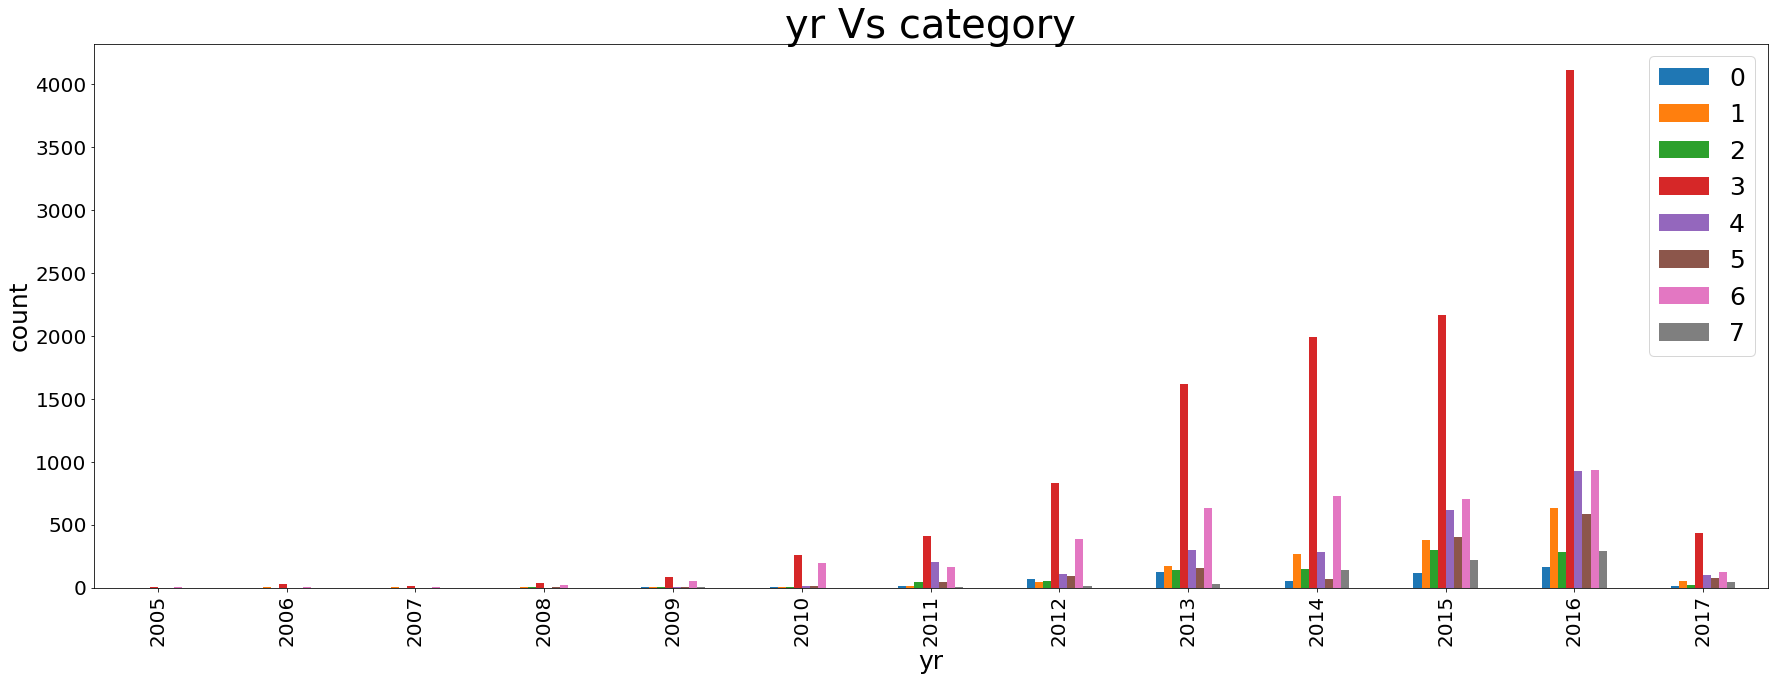

In [27]:
diff_bar('yr','category')

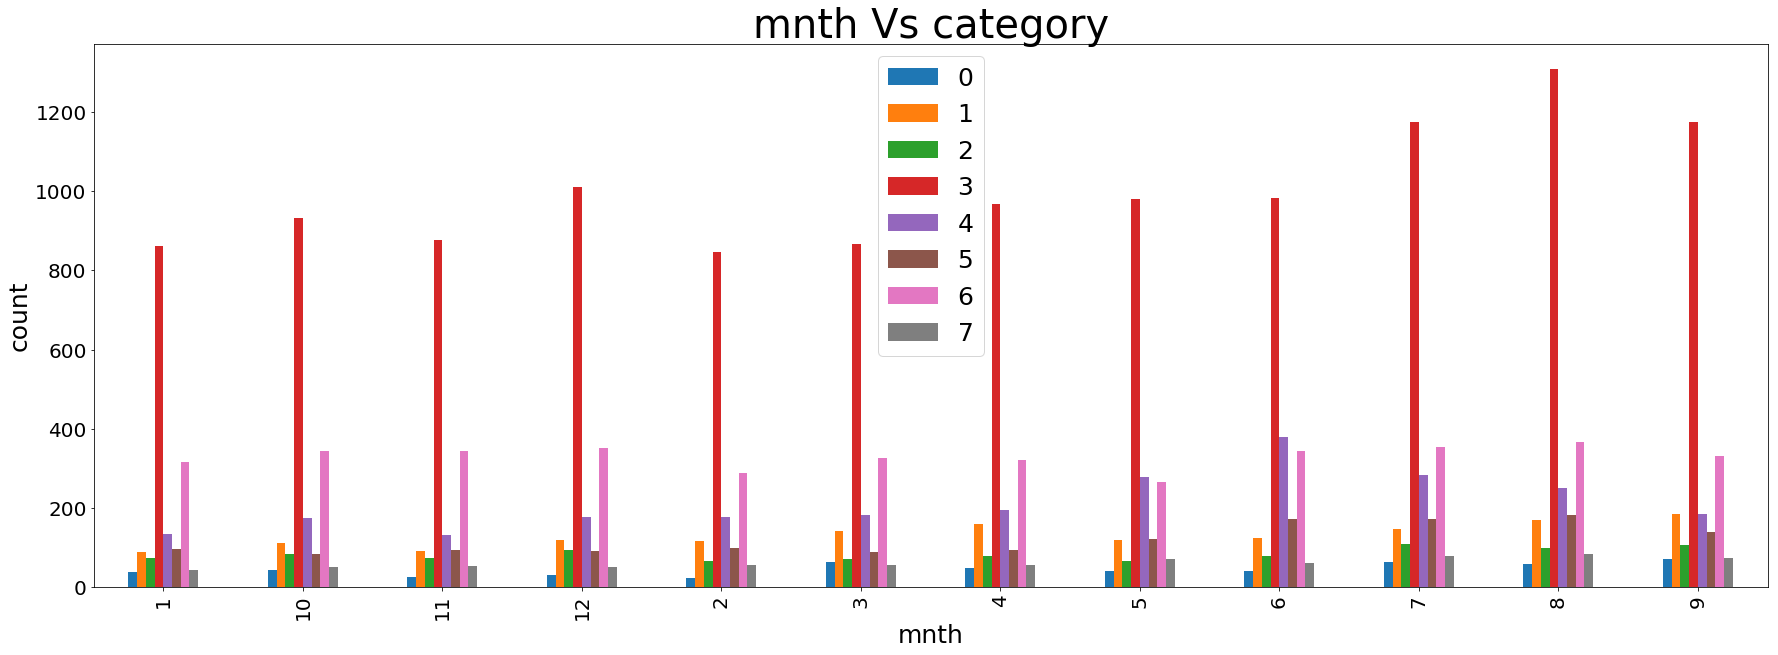

In [28]:
diff_bar('mnth','category')

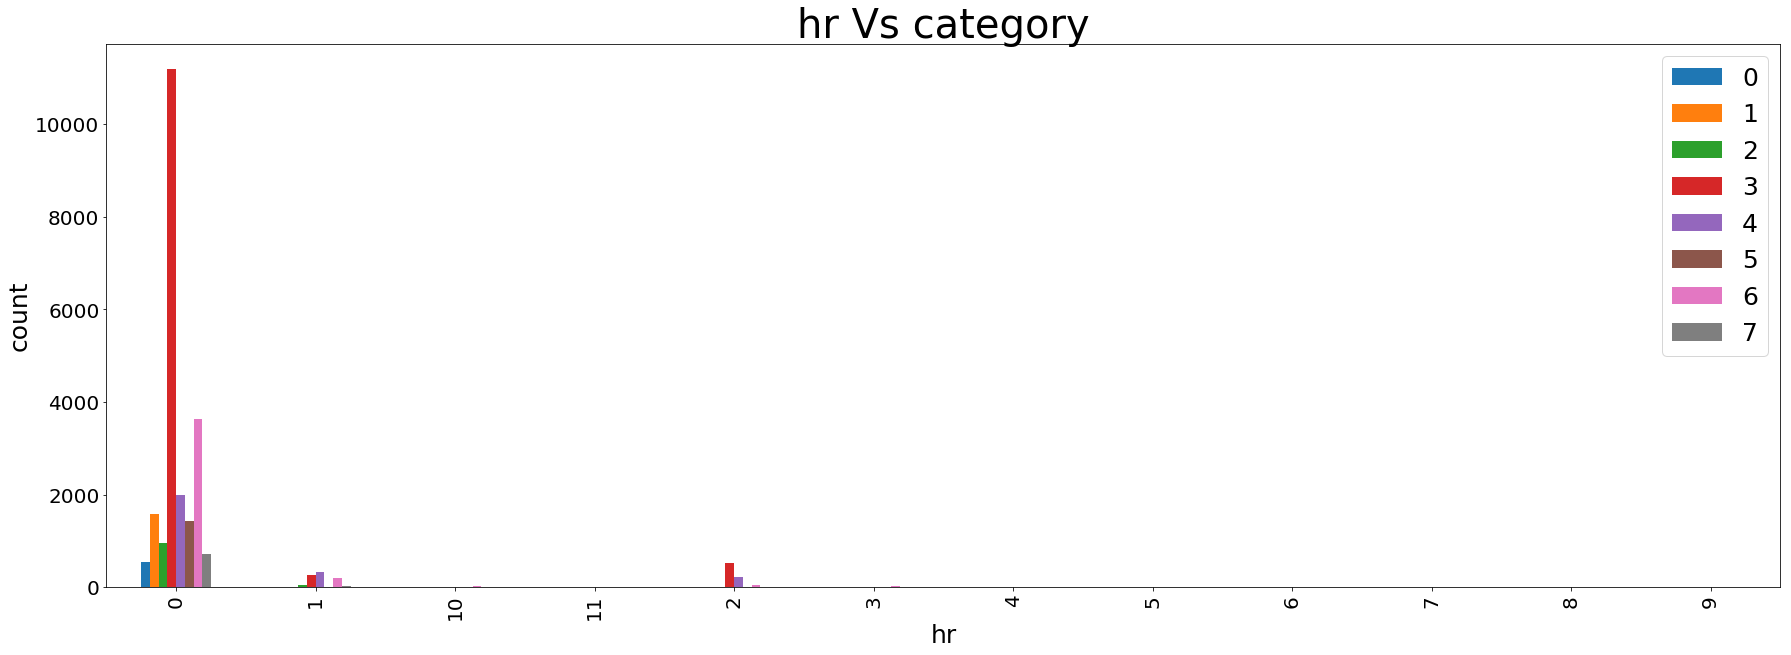

In [29]:
diff_bar('hr','category')

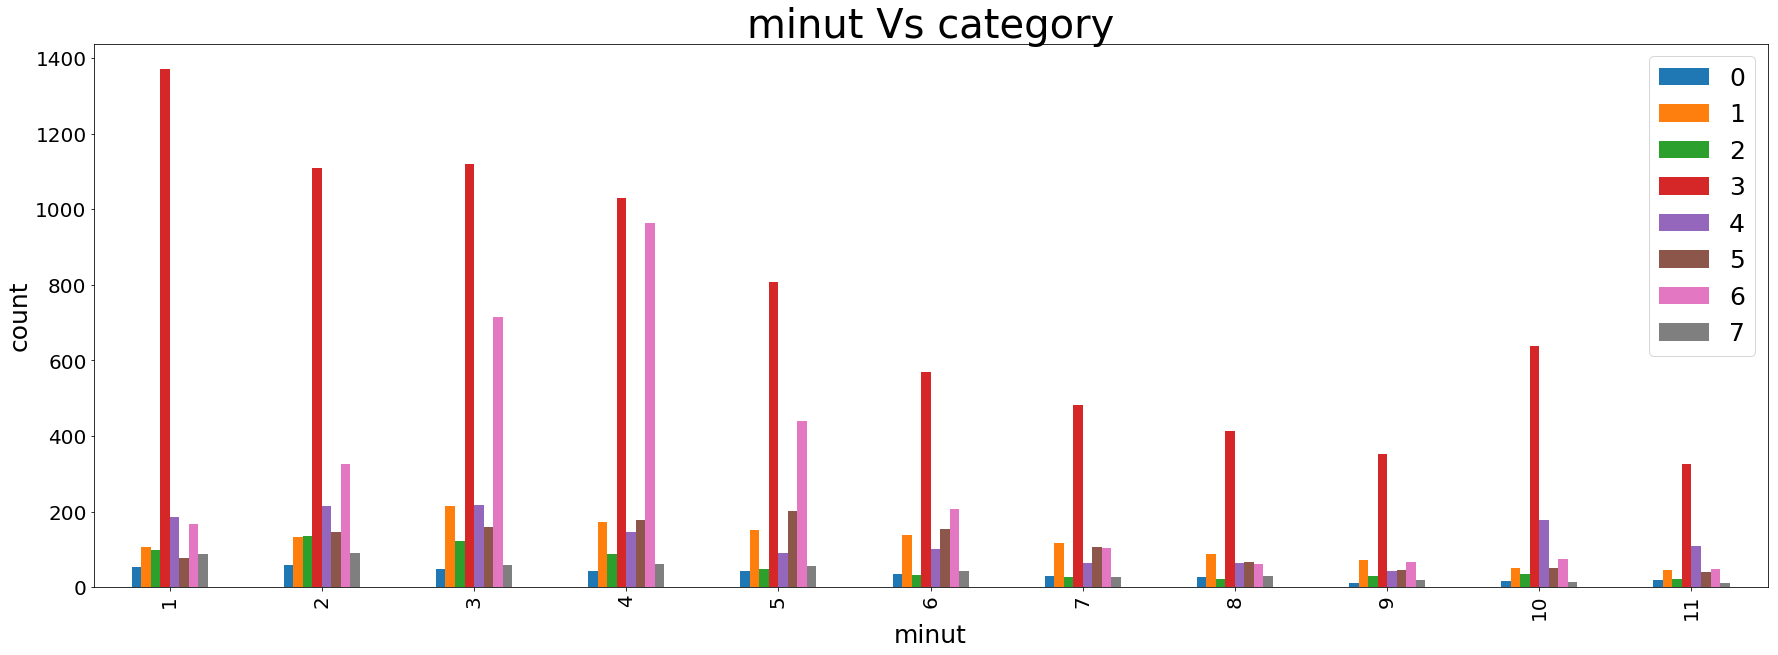

In [30]:
#Relationational bar graph for checking data distribution
def diff_bar(x,y):
    df.groupby([x,y]).size().unstack(level=-1).plot(kind='bar', figsize=(30,10))
    plt.xlabel(x,fontsize= 25)
    plt.ylabel('count',fontsize= 25)
    plt.xlim(0.5,11.5)
    plt.legend(loc=0,fontsize= 25)
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    plt.title("{X} Vs {Y}".format(X=x,Y=y),fontsize = 40)
    #plt.savefig("{X}_Vs_{Y}.png".format(X=x,Y=y))
    plt.show()
diff_bar('minut','category')    

In [31]:
train = df[['vidid','category','comment','totalsec','dislikes','likes','views','watch','hr','minut','sec','day','mnth','yr','adview']].dropna()
test = df.loc[df.adview.isnull(),['vidid','category','comment','totalsec','dislikes','likes','views','watch','hr','minut','sec','day','mnth','yr']]

train.adview = train.adview.astype(np.int64)

_____________

### Outliers Analysis

In [32]:
# for i in ['views','likes','dislikes','comment','watch']:
#     test[i].plot()
#     plt.show()

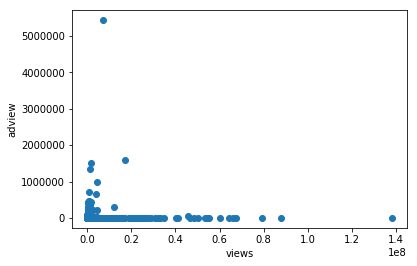

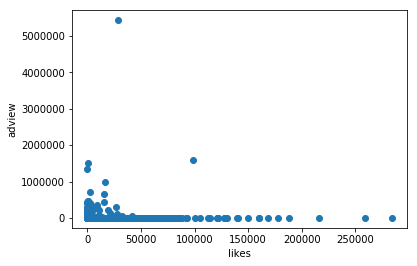

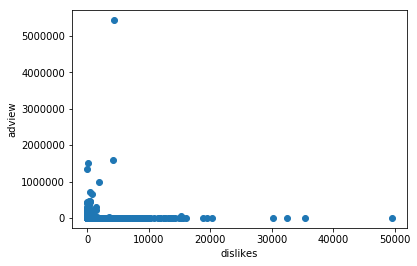

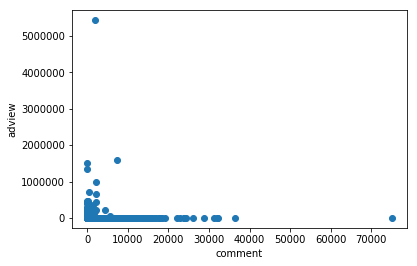

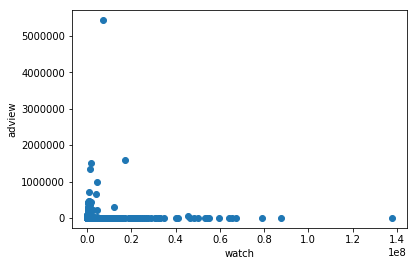

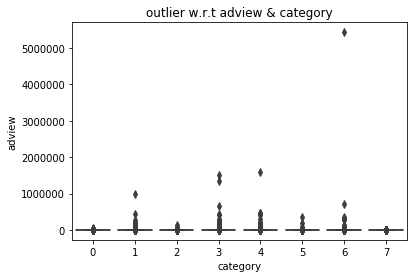

In [33]:
#Checking spread of data with respect to target variable outliers
for i in ['views','likes','dislikes','comment','watch']:
    plt.scatter(x=train[i], y=train.adview)
    plt.xlabel(i)
    plt.ylabel('adview')
    plt.show()
    
sns.boxplot(x='category', y="adview", data=train)
plt.title('outlier w.r.t adview & category')
plt.show()

We can see that there are some points which are extremly large or extremely low // will treat them as outlier

In [34]:
#manual removal
train = train.drop(train[train.adview > 5000000].index) #an huge outlier

#Treating Out Liers and Converting them with mean
for i in ['comment','dislikes','likes','views']:
    #print(i)
    q95, q5 = np.percentile(train.loc[:,i], [95 ,5])
    iqr = q95 - q5
    minn = q5 - (iqr*1.5)
    maxx = q95 + (iqr*1.5)
#Converting to mean value
    train.loc[train.loc[:,i] < minn,i] = round(train[i].mean())
    train.loc[train.loc[:,i] > maxx,i] = round(train[i].mean())

In [35]:
# #Checking spread of data with respect to target variable after outliers
# for i in ['views','likes','dislikes','comment']:
#     plt.scatter(x=train[i], y=train.adview)
#     plt.xlabel(i)
#     plt.ylabel('adview')
#     plt.show()
    
# sns.boxplot(x='category', y="adview", data=train)
# plt.title('outlier w.r.t adview & category')
# plt.show()

In [36]:
#All continous var list
cname = train.columns[(train.dtypes=="int64")].tolist()
print(cname)

['comment', 'totalsec', 'dislikes', 'likes', 'views', 'watch', 'minut', 'sec', 'day', 'adview']


# Feature Selecton

### 1.Correlation Analysis

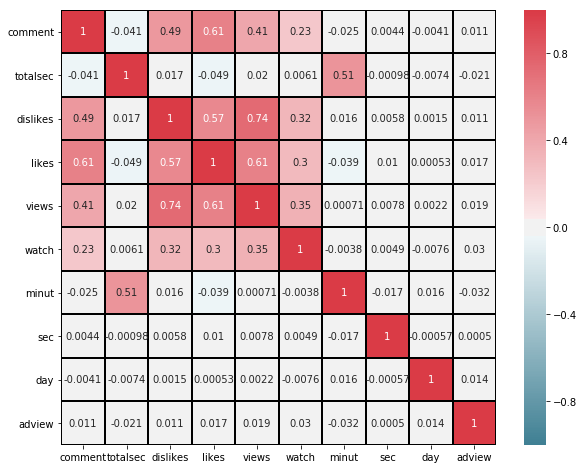

In [37]:
#Setting up the pane or matrix size
f, ax = plt.subplots(figsize=(10,8))  #Width,height

#Generating Corelation Matrix
corr = train[cname].corr()

#Plot using Seaborn library
sns.heatmap(corr,mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220,10, as_cmap=True),\
            square=True, ax=ax,annot=True,linewidths=1 , linecolor= 'black',vmin = -1, vmax = 1)

plt.show()
#f.savefig('heatmap.png')

Not so Highly correlated variables present

In [38]:
#removing _vidid colum
train = train.drop(['vidid','hr'],axis = 1)
test = test.drop('hr',axis = 1)

In [39]:
#add mnth,sec,day
for i in ['minut','sec','day']:
    train[i] = train[i].astype(str)
    test[i] = test[i].astype(str)

In [40]:
print(train.select_dtypes(exclude=np.number).columns.tolist())
print()
print(train.select_dtypes(include=np.number).columns.tolist())
train.head(1)

['category', 'minut', 'sec', 'day', 'mnth', 'yr']

['comment', 'totalsec', 'dislikes', 'likes', 'views', 'watch', 'adview']


,category,comment,totalsec,dislikes,likes,views,watch,minut,sec,day,mnth,yr,adview
0,5,1095,457,363,8523,1031602,1021621,7,37,14,9,2016,40


In [41]:
# def dummy_func(df):
#     #Extracting all object var
#     cat_names = df.select_dtypes(exclude=np.number).columns.tolist()
    
#     ##Creating Dummies
#     for i in cat_names:
#         dummies = pd.get_dummies(df[i], prefix= i, dummy_na=False)
#         df = df.drop(i, 1)
#         df = pd.concat([df, dummies],axis = 1)
        
#     #Converting back to object
#     for i in df.columns:
#         if df[i].dtypes == 'uint8':
#             df[i] = df[i].astype('object')
#     return df


# train_x = pd.DataFrame(train.iloc[:,:-1])
# train_y = train['adview']
# train = dummy_func(train_x)
# train = pd.concat([train, train_y],axis = 1)

In [42]:
print(train.shape)

(14998, 13)


###  Scaling

In [43]:
# for i in cname:
#     train[i].plot(title = i)
#     plt.show()

In [44]:
# train[cname].hist(figsize=(20,20),color='g',alpha = 0.7)
# plt.show()

In [45]:
cname = train.columns[(train.dtypes=="int64")].tolist()
cname.remove('adview')

def scale_standard(df):
    for i in cname:
        #print(i)
        df[i] = (df[i] - df[i].mean())/df[i].std()
    return df

train = scale_standard(train)
test = scale_standard(test)

#print(train.columns.tolist())
#print(train.shape)
train.head(2)

,category,comment,totalsec,dislikes,likes,views,watch,minut,sec,day,mnth,yr,adview
0,5,1.395361,-0.254571,0.521004,1.570384,0.558394,0.114827,7,37,14,9,2016,40
1,3,-0.443683,-0.205726,-0.489137,-0.480251,-0.562746,-0.260680,9,30,1,10,2016,2


## Best feature

In [46]:
# from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
# from sklearn.feature_selection import SelectKBest,f_regression
# X, y = train.iloc[:,:-1], train.iloc[:,-1]
# X_new = SelectKBest(f_regression, k=10).fit_transform(X, y)
# X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.20,random_state=101)

### Validation Sampling

In [47]:
from sklearn.model_selection import train_test_split,cross_val_score

X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,:-1],
                                                    train.iloc[:,-1],
                                                    test_size=0.20,
                                                    random_state=101)

# PCA


In [48]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=7)
# X_train = pca.fit_transform(X_train)
# X_test = pca.fit_transform(X_test)

# #Cumilative explained variance of the different coponents
# explained_variance = pca.explained_variance_ratio_

# explained_variance

### Modeling

In [49]:
from sklearn import metrics

def results(y_test,y_pred):
    print('R2 score ==>  ', round(metrics.r2_score(y_test, y_pred), 2))
    print(('Mean absolute percentage error ==>  {} % ').format(round(np.mean(np.abs((y_test - y_pred) / y_test))*100, 2)))
    print('Mean Squared Error ==>  ', round(metrics.mean_squared_error(y_test, y_pred), 2))
    print('Root Mean Squared Error ==> ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2))

def cross_val(model):
    acc = cross_val_score(model, X_train, y_train, cv=10,scoring='r2',n_jobs=-1,)
    print('Mean Score of Cross validation = ',round(acc.mean(),2))
    print('Standard Deviation of CV = ',round(acc.std(),2))    
    
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    results(y_train,y_pred)
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(X_test)
    results(y_test,y_pred)

# Linear regression

In [50]:
#from sklearn.linear_model import LinearRegression

linear_model = LinearRegression().fit(X_train,y_train)
test_scores(linear_model)
print('---------')

#cross_val(linear_model)
# # Mean Score of Cross validation =  -0.01
# # Standard Deviation of CV =  0.02

<<<------------------- Training Data Score --------------------->

R2 score ==>   0.01
Mean absolute percentage error ==>  110530.85 % 
Mean Squared Error ==>   643631162.2
Root Mean Squared Error ==>  25369.89

<<<------------------- Test Data Score --------------------->

R2 score ==>   0.0
Mean absolute percentage error ==>  111536.23 % 
Mean Squared Error ==>   1300917212.86
Root Mean Squared Error ==>  36068.23
---------


### Decision Tree

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=101).fit(X_train,y_train)
test_scores(tree_model)

print('-------')

#cross_val(tree_model)
# # Mean Score of Cross validation =  -2.03
# # Standard Deviation of CV =  3.73

<<<------------------- Training Data Score --------------------->

R2 score ==>   1.0
Mean absolute percentage error ==>  0.0 % 
Mean Squared Error ==>   0.0
Root Mean Squared Error ==>  0.0

<<<------------------- Test Data Score --------------------->

R2 score ==>   -0.25
Mean absolute percentage error ==>  71962.04 % 
Mean Squared Error ==>   1636352627.37
Root Mean Squared Error ==>  40451.86
-------


### RF

In [52]:
#from sklearn.ensemble import RandomForestRegressor

#forest_model = RandomForestRegressor(max_depth= 15, max_features = 'sqrt',n_estimators = 500,random_state=101,n_jobs = -1).fit(X_train,y_train)

forest_model = RandomForestRegressor(n_estimators=500, random_state=101,n_jobs = -1).fit(X_train,y_train)
test_scores(forest_model)

print('--------')
#cross_val(forest_model)

# # Mean Score of Cross validation =  0.07
# # Standard Deviation of CV =  0.23

<<<------------------- Training Data Score --------------------->

R2 score ==>   0.86
Mean absolute percentage error ==>  31603.2 % 
Mean Squared Error ==>   91748944.38
Root Mean Squared Error ==>  9578.57

<<<------------------- Test Data Score --------------------->

R2 score ==>   0.05
Mean absolute percentage error ==>  80450.68 % 
Mean Squared Error ==>   1243723686.04
Root Mean Squared Error ==>  35266.47
--------


In [53]:
#Tried this aproch but result was merly equal to Random forest result so commented

# from sklearn.linear_model import Ridge,Lasso
# tree = DecisionTreeRegressor().fit(X_train,y_train)
# rf1 = RandomForestRegressor(n_estimators=500, n_jobs = -1).fit(X_train,y_train)
# rf2 = RandomForestRegressor(n_estimators=1000, min_samples_leaf=150, max_depth=5, n_jobs = -1).fit(X_train,y_train)
# rf3 = RandomForestRegressor(n_estimators=10,max_features=3, min_samples_split=4,n_jobs = -1).fit(X_train,y_train)
# rf3 = RandomForestRegressor(n_estimators=300,max_depth=8,n_jobs = -1).fit(X_train,y_train)
# svr1 = SVR().fit(X_train,y_train)
# rdg = Ridge().fit(X_train,y_train)
# laso = Lasso().fit(X_train,y_train)
# model = {'tree':tree,'rf1':rf1,'rf2':rf2,'rf3':rf3,'svr1':svr1,'rdg':rdg,'lasso':laso}

# y_pred = pd.DataFrame()
# #pred_li = []
# for i in model:
#     y_pred[i] = model[i].predict(X_test)
# pred = list(round(y_pred.mean(axis = 1)))  

# results(y_test,pred)

# Random Forest Perform better than all other 

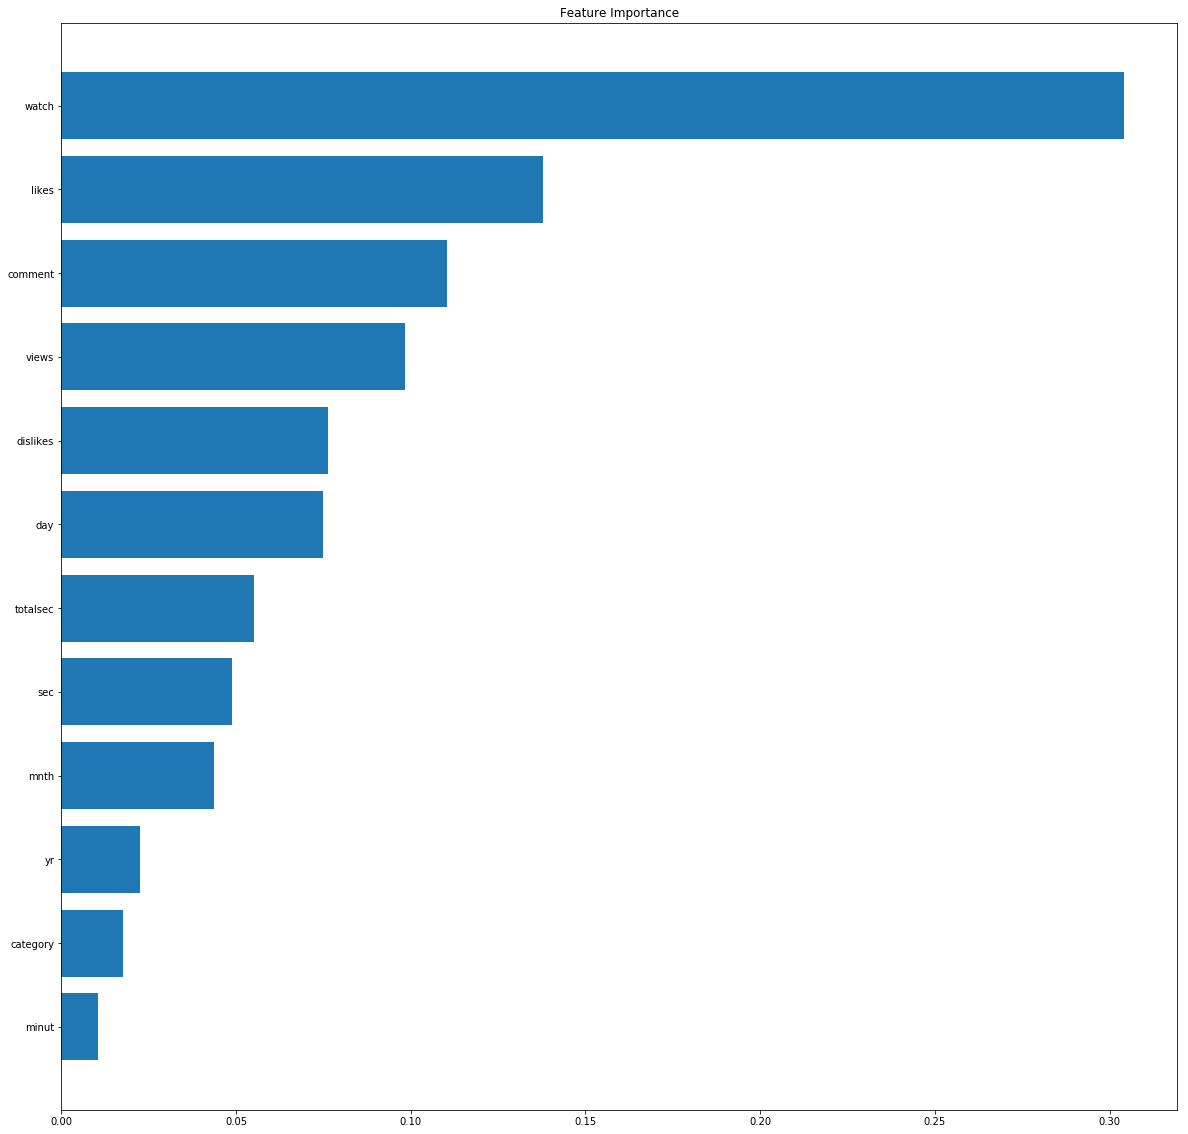

In [54]:
#Calculating feature importances
importances = forest_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [train.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(X_train.shape[1]),importances[indices],align = 'center')
plt.yticks(range(X_train.shape[1]), names)
plt.show()
#fig.savefig('feature_importance.png')

In [55]:
train.columns

Index(['category', 'comment', 'totalsec', 'dislikes', 'likes', 'views',
       'watch', 'minut', 'sec', 'day', 'mnth', 'yr', 'adview'],
      dtype='object')

In [56]:
test.columns

Index(['vidid', 'category', 'comment', 'totalsec', 'dislikes', 'likes',
       'views', 'watch', 'minut', 'sec', 'day', 'mnth', 'yr'],
      dtype='object')

### Finaly Prediction

In [57]:
final_model = RandomForestRegressor(n_estimators=500, random_state=101,n_jobs = -1).fit(train.iloc[:,:-1],train.iloc[:,-1])
test['ad_view'] = final_model.predict(test.iloc[:,1:])
test.head()

,vidid,category,comment,totalsec,dislikes,likes,views,watch,minut,sec,day,mnth,yr,ad_view
0,VID_1054,1,0.436138,-0.254719,-0.044062,0.328864,-0.085596,-0.086917,7,29,18,2,2017,1340.878
1,VID_18629,5,0.278326,-0.278864,0.072164,0.532326,0.076657,0.075228,6,29,28,6,2016,3370.700
2,VID_13967,3,-0.221889,0.479703,-0.241266,-0.288379,-0.196950,-0.196444,37,54,10,3,2014,14.648
3,VID_19442,6,-0.091336,-0.195965,-0.013577,-0.061223,0.151465,0.152042,9,55,5,6,2010,653.142
4,VID_770,1,-0.166894,-0.359752,-0.037394,-0.037530,0.307379,0.308310,3,8,3,9,2016,6101.116


In [58]:
#Output
test = test.rename(columns={'vidid':'vid_id'})
test[['vid_id','ad_view']].to_csv('data/mn/output.csv')